In [1]:
import Waveforms
from Waveforms import *

2023-03-16 13:00:29.337359: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-03-16 13:00:29.428686: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-03-16 13:00:29.430966: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIB

In [2]:
from importlib import reload
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
reload(Waveforms)
from Waveforms import *

In [ ]:
SXS_num = "0305"
l, m = 4, 4
h_hi, _, _, Level, _ = get_waveform_SXS(SXS_num, 4, 4, res = 0)
h_low, _, _, Level, _ = get_waveform_SXS(SXS_num, 4, 4, res = -1)
t_low_more, h_low_more_r, h_low_more_i = h_low.postmerger(-10)
h_low_more = h_low_more_r + 1.j*h_low_more_i

Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev5/metadata.json


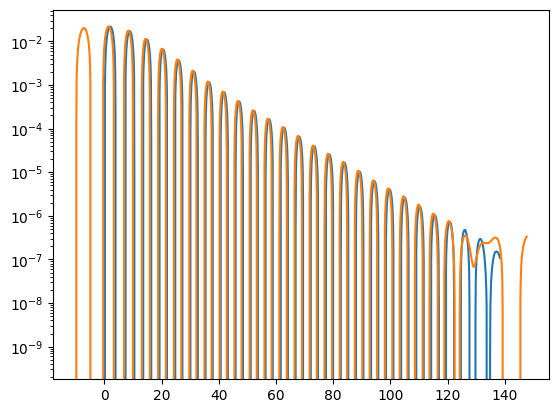

In [17]:
fig, ax = plt.subplots()

ax.semilogy(h_hi.time[:-100], (h_hi.hi[:-100]))
ax.semilogy(t_low_more, (h_low_more_i))

In [4]:
def compute_mismatch(t1, h1, t2, h2, tnum = 2000):
    t_low = t1[0]
    t_hi = min(t1[-1], t2[-1])
    t_grid = np.linspace(t_low, t_hi, num = max(tnum, len(t1)))
    h1_interp = griddata(t1, h1, t_grid)
    h2_interp = griddata(t2, h2, t_grid)
    mismatch = 1 - (np.real(np.vdot(h1_interp, h2_interp) / (
                    np.linalg.norm(h1_interp) * np.linalg.norm(h2_interp))))
    return mismatch


def mismatch_dphi_dt(dphi_dt, t1, h1, t2, h2, tnum = 2000):
    dphi = dphi_dt[0]
    dt = dphi_dt[1]
    t2_shift = t2 + dt
    h2_shift = h2*np.exp(1.j*dphi)
    return compute_mismatch(t1, h1, t2_shift, h2_shift, tnum = tnum)

def mismatch_min_phase(t1, h1, t2, h2, tnum = 2000):
    res = minimize(mismatch_dphi_dt, x0 = [0, 0], args=(t1, h1, t2, h2),
                   method = 'Nelder-Mead', tol = 1e-13)
    return res


In [5]:
SXS_num = "0305"
l, m = 4, 4

def estimate_resolution_mismatch(SXS_num, l, m, t0s = np.linspace(0, 50, num = 51), remove_end = 100):
    h_hi, _, _, Level, _ = get_waveform_SXS(SXS_num, l, m, res = 0)
    h_low, _, _, Level, _ = get_waveform_SXS(SXS_num, l, m, res = -1)
    t_low_more, h_low_more_r, h_low_more_i = h_low.postmerger(-10)
    h_low_more = h_low_more_r + 1.j*h_low_more_i

    mismatches = []
    res = None
    for t0 in t0s:
        t_hi_adj, h_hi_adj_r, h_hi_adj_i = h_hi.postmerger(t0)
        t_low_adj, h_low_adj_r, h_low_adj_i = h_low.postmerger(t0 - 5)
        h_hi_adj = h_hi_adj_r + 1.j*h_hi_adj_i
        h_low_adj = h_low_adj_r + 1.j*h_low_adj_i
        if t0 == 0:
            res = mismatch_min_phase(t_hi_adj[:-remove_end-1],
                                    h_hi_adj[:-remove_end-1], 
                                    t_low_adj, 
                                    h_low_adj)
            mismatches.append(res.fun)
            dphi = res.x[0]
            dt = res.x[1]
        else:
            mismatch = compute_mismatch(t_hi_adj[:-remove_end-1], 
                                        h_hi_adj[:-remove_end-1], 
                                        t_low_adj + dt,
                                        h_low_adj*np.exp(1.j*dphi))
            mismatches.append(mismatch)
    
    return mismatches

In [6]:
mismatches = estimate_resolution_mismatch(SXS_num, l, m)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


2023-03-16 13:02:50.396387: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-03-16 13:02:50.396421: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev5/metadata.json


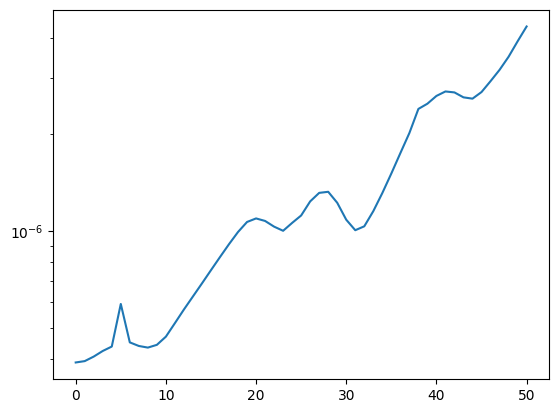

In [7]:
plt.semilogy(np.linspace(0, 50, num = 51), mismatches)